In [19]:
import numpy as np
import dask.dataframe as dd
import pandas as pd
from mlt.default import selector as s
import cv2, os
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [20]:
!ls ../20181109_vml_dump/*.h5

../20181109_vml_dump/attr_query.h5   ../20181109_vml_dump/text_query.h5
../20181109_vml_dump/image_query.h5


# Configs

In [23]:
ATTR_DATA_FILE1 = "../20181109_vml_dump/attr_query.h5"
IMAGE_DATA_FILE1 = "../20181109_vml_dump/image_query.h5"
ATTR_DATA_FILE2 = "raw_attribute_data_shrek_cleaned.h5"
IMAGE_DATA_FILE2 = "raw_image_data_patrick.h5"

# Please choose limited CATEGORIES. This will avoid Memory issues.
SELECTED_CATEGORIES1 = ['Area Area Rug', 'Bath Rug', 'Bath Rugs', 'Rug', 'Area Rug']
SELECTED_CATEGORIES2 = ['BATH_RUGS', 'RUG', 'AREA_AREA_RUG', 'AREA_RUG', 'BATH_RUG']

# optional config. Make it empty list if not used.
#SELECTED_ATTRIBUTES = ['Handbag Style', 'Handbag Size', 'Handbag Occasion', 'Handbag Material']
SELECTED_ATTRIBUTES = []

# CHANGE THIS
SAVE_OUTPUT_AS = "RUGS_IDM_1118_and_0119_DATA.csv"

# Configs Validation

In [24]:
if len(SELECTED_CATEGORIES1) == 0:
    print("ERROR: Please limit your SELECTED_CATEGORIES. Otherwise it takes too long. May also run out of memory.")
    for _ in range(10):
        print("STOP")

# Load IDM raw files

In [25]:
# load attr file
raw_attr1 = pd.read_hdf(ATTR_DATA_FILE1)
raw_attr2 = pd.read_hdf(ATTR_DATA_FILE2)
print("count raw_attr1", len(raw_attr1))
print("count raw_attr2", len(raw_attr2))
raw_attr1.head()

count raw_attr1 23585346
count raw_attr2 24503412


,PROD_ID,ATTR_NAME,ATTR_VAL
0,9,Color Family,Black
1,9,Color Family,Blue
2,9,NRF_ID,1
3,9,NRF_ID,370
4,9,NRF_ID,401


In [26]:
# doesn't show any duplicates
#print(raw_attr1.drop_duplicates(keep='first').shape, raw_attr2.drop_duplicates(keep='first').shape)

In [27]:
# does show a few duplicates
raw_attr = pd.concat([raw_attr1, raw_attr2])
print(raw_attr.shape, raw_attr.drop_duplicates(keep='first').shape)

(48088758, 3) (26505654, 3)


In [28]:
raw_attr = raw_attr.drop_duplicates(keep='first')

In [29]:
unique_cats = raw_attr[raw_attr['ATTR_NAME'] == 'Category']['ATTR_VAL']
unique_cats = list(set(unique_cats))
unique_cats

['Sleepwear',
 'TOTE',
 'LUGGAGE',
 'Mascara',
 'Sheets',
 'SCARVES',
 'PANTS',
 'Kitchen',
 'SHEERS',
 'FRAMES',
 'Wallet',
 'TREES_AND_WREATHS',
 'Towel',
 'Jewelry Boxes',
 'BEDDING',
 'TOASTER',
 'SHIRTS',
 'Trees And Wreaths',
 'VIRTUAL_GIFT_CARD',
 'BASE',
 'Garter Belt',
 'Kitchen Linen',
 'Table Linen',
 'BEAUTY_TOOLS',
 'BOTANICALS',
 'Sheers',
 'Belt',
 'Coats',
 'Tuxedo 3',
 'GWP',
 'Window Collection',
 'STONEWARE',
 'Fountains',
 'ONE_PIECE',
 'China',
 'Concealer',
 'Tiers',
 'DUFFLE',
 'LIPSTICK',
 'Scarf Set',
 'FRAGRANCE_SET',
 'SANDALS',
 'Toaster Oven',
 'GIFT_CERTIFICATE',
 'Baby Sets',
 'TREES_&_WREATHS',
 'Sandal',
 'Cookware Set',
 'JUMPSUITS_&_ROMPERS',
 'Business And Laptop',
 'WATCHES',
 'BACKPACKS_AND_MESSENGERS',
 'Toaster',
 'Food Processors',
 'Personal Care',
 'Cufflinks',
 'Slip Covers',
 'Toaster Ovens',
 'Tea Kettles',
 'SWIMSUIT',
 'Flatware',
 'SLIP_COVER',
 'Frames',
 'SLOW_COOKER',
 'Top',
 'FOOD_PROCESSORS',
 'Scarf',
 'JUICER',
 'Coat',
 'BLANKET

In [30]:
[x for x in unique_cats if 'rug' in x.lower()]

['Bath Rugs',
 'RUG',
 'AREA_RUG',
 'Area Area Rug',
 'Bath Rug',
 'BATH_RUGS',
 'AREA_AREA_RUG',
 'BATH_RUG',
 'Area Rug',
 'Rug']

In [31]:
# convert Top's -> TOPS 
# basically remove all single quotes and brackets so df_query will work without issues later
# 
# this step takes a long time. So I have saved its output as raw_attribute_data_shrek_cleaned.h5
def clean_category_value(row):
    name = row['ATTR_NAME']
    val = row['ATTR_VAL']
    if name == 'Category':
        val = val.upper()
        val = val.replace(" ", "_")
        val = val.replace("'", "")
    return val 

#raw_attr['ATTR_VAL'] = raw_attr.apply(clean_category_value, axis=1)
#raw_attr.head()

In [32]:
# apparently there are no duplicates ? strange. I guess if I subsetted by image id there would be
#print(raw_attr.shape, raw_attr.drop_duplicates(keep='first').shape)

In [33]:
# load image file
raw_image1 = pd.read_hdf(IMAGE_DATA_FILE1)
raw_image2 = pd.read_hdf(IMAGE_DATA_FILE2)

In [34]:
# some differences but we'll catch them all together
print(raw_image1.shape, raw_image2.shape, raw_image1.drop_duplicates(keep='first').shape, raw_image2.drop_duplicates(keep='first').shape)

(4911150, 10) (1839755, 10) (4906419, 10) (1838724, 10)


In [35]:
raw_image1.head(2)

,PRODUCT_ID,IMAGE_ID,COLORWAY_IMAGE_ROLE_TYPE,COLOR_NORMAL,COLOR,NRF_COLOR_CODE,NRF_COLOR,UPC_DESC,IMG_DESC,HOW_SHOT_TXT
0,2543257,3334533,CPRI,White,#130 Natur,100.0,WHITE,None,FEM CLASSIC SS #130 Natur,On-Figure
1,5616220,9256822,CPRI,Tan/Beige,0.75 Ivory,271.0,28IVORY,Bobbi Brown Skin Long-Wear Weightless Foundation,None,None


In [36]:
raw_image2.head(2)

,PRODUCT_ID,IMAGE_ID,COLORWAY_IMAGE_ROLE_TYPE,COLOR_NORMAL,COLOR,NRF_COLOR_CODE,NRF_COLOR,UPC_DESC,IMG_DESC,HOW_SHOT_TXT
0,5923807,9359780,CPRI,Multi,CLASSIC BLUE,974.0,CLASSIC BL,New Balance Men's 574 Casual Sneakers from Fin...,New Balance - null - null,VENDOR_CHROME
1,5923807,9359786,CADD,Multi,CLASSIC BLUE,974.0,CLASSIC BL,New Balance Men's 574 Casual Sneakers from Fin...,New Balance - null - null,VENDOR_CHROME


### MAKE CORRECT IMAGE PATHS FOR EACH FILE

In [37]:
!ls /home/jovyan/vmldata/raw_source_data/

data_clean.tar.gz		      v20180831_dresses_high_resolution
exact_street_2_shop_preprocessed      v20181001_fashion_ai_attributes
images_folder			      v20181008_polyvore_data
metadata_all_categories_12242018.csv  v20181018_live_web_images
polyvore			      v20181022_style_data
product_attributes		      v20181022_style_data_v2
ray_images			      v20181105_third_opinion_v01
second_opinion_attribute_data	      v20181129_idm_extract
style_data.tar.gz		      v20181212_websnap
v20180301_pot_dataset		      v20190104_idm_validation_data
v20180701_all_wearables		      websnap.tar.bz2
v20180810_all_wearables


In [38]:
root1 = '/home/jovyan/vmldata/raw_source_data/v20181129_idm_extract/'
root2 = '/home/jovyan/vmldata/raw_source_data/v20190104_idm_validation_data/'

def make_image_filename(row):
    pid = str(row['PRODUCT_ID'])
    return pid[0] + '/' + pid[1] + '/' + pid + '_' + str(row['IMAGE_ID']) + '.jpg'

def make_image_filename1(row):
    pid = str(row['PRODUCT_ID'])
    return root1 + pid[0] + '/' + pid[1] + '/' + pid + '_' + str(row['IMAGE_ID']) + '.jpg'

def make_image_filename2(row):
    pid = str(row['PRODUCT_ID'])
    return root2 + pid[0] + '/' + pid[1] + '/' + pid + '_' + str(row['IMAGE_ID']) + '.jpg'

raw_image1['IMAGE_FILE'] = raw_image1.apply(make_image_filename, axis=1)
raw_image2['IMAGE_FILE'] = raw_image2.apply(make_image_filename, axis=1)
# raw_image1['IMAGE_FILE'] = raw_image1.apply(make_image_filename1, axis=1)
# raw_image2['IMAGE_FILE'] = raw_image2.apply(make_image_filename2, axis=1)

In [39]:
raw_image1.head(2)

,PRODUCT_ID,IMAGE_ID,COLORWAY_IMAGE_ROLE_TYPE,COLOR_NORMAL,COLOR,NRF_COLOR_CODE,NRF_COLOR,UPC_DESC,IMG_DESC,HOW_SHOT_TXT,IMAGE_FILE
0,2543257,3334533,CPRI,White,#130 Natur,100.0,WHITE,None,FEM CLASSIC SS #130 Natur,On-Figure,2/5/2543257_3334533.jpg
1,5616220,9256822,CPRI,Tan/Beige,0.75 Ivory,271.0,28IVORY,Bobbi Brown Skin Long-Wear Weightless Foundation,None,None,5/6/5616220_9256822.jpg


In [40]:
raw_image1['IMAGE_FILE'][0]

'2/5/2543257_3334533.jpg'

In [41]:
raw_image = pd.concat([raw_image1, raw_image2])

In [42]:
print(raw_image.shape)
raw_image = raw_image.drop_duplicates(keep='first')
print(raw_image.shape)

(6750905, 11)
(5365499, 11)


In [43]:
raw_image = raw_image[raw_image['COLORWAY_IMAGE_ROLE_TYPE'] == 'CPRI']
raw_image = raw_image[['PRODUCT_ID', 'IMAGE_ID', 'IMAGE_FILE']]

print("count raw_image", len(raw_image))

raw_image.head()

count raw_image 2695490


,PRODUCT_ID,IMAGE_ID,IMAGE_FILE
0,2543257,3334533,2/5/2543257_3334533.jpg
1,5616220,9256822,5/6/5616220_9256822.jpg
4,393197,8424864,3/9/393197_8424864.jpg
7,2918849,3812878,2/9/2918849_3812878.jpg
14,1186655,1857330,1/1/1186655_1857330.jpg


# Filter Attributes df for Selected Categories

In [44]:
SELECTED_CATEGORIES = SELECTED_CATEGORIES1 + SELECTED_CATEGORIES2
SELECTED_CATEGORIES

['Area Area Rug',
 'Bath Rug',
 'Bath Rugs',
 'Rug',
 'Area Rug',
 'BATH_RUGS',
 'RUG',
 'AREA_AREA_RUG',
 'AREA_RUG',
 'BATH_RUG']

In [45]:
# if no categories are provided then use all unique categories from the data
if len(SELECTED_CATEGORIES) == 0:
    UNIQUE_CATEGORIES = list(set(raw_attr[raw_attr['ATTR_NAME'] == 'Category']['ATTR_VAL']))
    SELECTED_CATEGORIES = UNIQUE_CATEGORIES
    
# collect unique attributes for selected categories
if len(SELECTED_CATEGORIES) == 1:
    query_string = 'ATTR_NAME == "Category" and ATTR_VAL == "{}"'.format(str(SELECTED_CATEGORIES[0]))
else:
    query_string = 'ATTR_NAME == "Category" and (ATTR_VAL == "{}"'.format(str(SELECTED_CATEGORIES[0]))
    for idx, SELECTED_CATEGORY in enumerate(SELECTED_CATEGORIES):
        if idx == 0: continue
        query_string = query_string + ' or ATTR_VAL == "{}"'.format(str(SELECTED_CATEGORY))
    query_string = query_string + ")"

print("\n", "query_string:", query_string)

cat_df = raw_attr.query(query_string)
cat_pids = list(set(cat_df['PROD_ID']))
cat_df = raw_attr.loc[raw_attr['PROD_ID'].isin(cat_pids)] 
print("\n", "df shape:", cat_df.shape)

cat_df.head()


 query_string: ATTR_NAME == "Category" and (ATTR_VAL == "Area Area Rug" or ATTR_VAL == "Bath Rug" or ATTR_VAL == "Bath Rugs" or ATTR_VAL == "Rug" or ATTR_VAL == "Area Rug" or ATTR_VAL == "BATH_RUGS" or ATTR_VAL == "RUG" or ATTR_VAL == "AREA_AREA_RUG" or ATTR_VAL == "AREA_RUG" or ATTR_VAL == "BATH_RUG")

 df shape: (569241, 3)


,PROD_ID,ATTR_NAME,ATTR_VAL
21678,32016,Bath Category,Bath Rugs
21679,32016,Brand,Calvin Klein
21680,32016,Category,Bath Rug
21681,32016,Category of Business,Bed & Bath
21682,32016,Category of Business,Home


In [52]:
raw_attr[raw_attr['PROD_ID'] == 32016]

,PROD_ID,ATTR_NAME,ATTR_VAL
21678,32016,Bath Category,Bath Rugs
21679,32016,Brand,Calvin Klein
21680,32016,Category,Bath Rug
21681,32016,Category of Business,Bed & Bath
21682,32016,Category of Business,Home
21683,32016,Home Categories,Bath
21684,32016,Style,Classic
21685,32016,Style,Modern
21686,32016,Style,Traditional
21672,32016,Category,BATH_RUG


In [53]:
cat_df.head(2)

,PROD_ID,ATTR_NAME,ATTR_VAL
21678,32016,Bath Category,Bath Rugs
21679,32016,Brand,Calvin Klein


### FIX CATEGORY ATTR VALS

In [54]:
cat_df.loc[:,'ATTR_VAL'] = cat_df['ATTR_VAL'].str.lower()
cat_df.loc[:,'ATTR_VAL'] = cat_df['ATTR_VAL'].str.replace("_","")
cat_df.loc[:,'ATTR_VAL'] = cat_df['ATTR_VAL'].str.replace(" ","")
cat_df.loc[:,'ATTR_VAL'] = cat_df['ATTR_VAL'].str.replace("'", "")
cat_df.head(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,PROD_ID,ATTR_NAME,ATTR_VAL
21678,32016,Bath Category,bathrugs
21679,32016,Brand,calvinklein
21680,32016,Category,bathrug
21681,32016,Category of Business,bed&bath
21682,32016,Category of Business,home
21683,32016,Home Categories,bath
21684,32016,Style,classic
21685,32016,Style,modern
21686,32016,Style,traditional
21687,32017,Bath Category,bathrugs


In [55]:
image_pids = list(set(raw_image['PRODUCT_ID']))

print("cat_pids", len(cat_pids))
print("image_pids", len(image_pids))


inter = list(set(cat_pids) & set(image_pids))
print("inter", len(inter))


cat_pids 49530
image_pids 1412270
inter 18462


### MERGE THREE COLOR CATEGORIES

In [56]:
rug_color = cat_df.query('ATTR_NAME == "Rug Color"')
prod_color = cat_df.query('ATTR_NAME == "Product Color"')
fam_color = cat_df.query('ATTR_NAME == "Color Family"')
rp_color = pd.concat([rug_color, prod_color, fam_color])

In [57]:
rp_color.loc[:,'ATTR_NAME'] = rp_color['ATTR_NAME'].str.replace("Rug Color","Color")
rp_color.loc[:,'ATTR_NAME'] = rp_color['ATTR_NAME'].str.replace("Product Color","Color")
rp_color.loc[:,'ATTR_NAME'] = rp_color['ATTR_NAME'].str.replace("Color Family","Color")

In [58]:
rp_color.head(2)

,PROD_ID,ATTR_NAME,ATTR_VAL
101340,124351,Color,multi
101349,124352,Color,multi


In [59]:
rp_color['ATTR_VAL'].value_counts()

multi          20673
blue           10046
tan/beige       6704
gray            6432
brown           5299
ivory/cream     4766
red             4283
green           4059
black           3079
orange          1648
white           1121
gold            1052
pink            1049
purple           731
yellow           590
silver           554
Name: ATTR_VAL, dtype: int64

In [60]:
cat_df = pd.concat([cat_df, rp_color])
cat_df.head()

,PROD_ID,ATTR_NAME,ATTR_VAL
21678,32016,Bath Category,bathrugs
21679,32016,Brand,calvinklein
21680,32016,Category,bathrug
21681,32016,Category of Business,bed&bath
21682,32016,Category of Business,home


# Pivot cat_df

In [61]:
def dedup_rows(x):
    if len(x) > 1:
        o = set([i for i in x])
        return ', '.join(o)
    else:
        return x
    
aggregations = {
    'ATTR_VAL': dedup_rows
}
cat_df_pivoted = cat_df.groupby(['PROD_ID', 'ATTR_NAME']).agg(aggregations).reset_index()
cat_df_pivoted = cat_df_pivoted.pivot(index='PROD_ID', columns='ATTR_NAME', values='ATTR_VAL')
print("\n", "shape cat_df_pivoted", cat_df_pivoted.shape)
cat_df_pivoted.head()


 shape cat_df_pivoted (49530, 88)


ATTR_NAME,Active Apparel Type,Age Group,Area Rugs,Bath Accessory Style,Bath Category,Bath Type,Bed & Bath Type,Bed Size,Bedding Color,Bedding Features,...,Table Linen Type,Textiles Bed Size,Top Style,Towel Fabric,Towel Size,Towel Style,Underwear Style,Weather,Wedding Registry,Window Type
PROD_ID,,,,,,,,,,,,,,,,,,,,,
32016,NaN,NaN,NaN,NaN,bathrugs,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32017,NaN,NaN,NaN,NaN,bathrugs,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65749,NaN,adult,NaN,NaN,bathrugs,NaN,bath,NaN,"grey, brown/tan, purple, white/ivory, green",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92530,NaN,NaN,NaN,NaN,bathrugs,NaN,bath,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merge ImageData with AttributeData

In [62]:
merged_df = raw_image.merge(cat_df_pivoted, left_on="PRODUCT_ID", right_on="PROD_ID")
print("\n", "shape merged_df", merged_df.shape)
merged_df.tail()


 shape merged_df (42773, 91)


,PRODUCT_ID,IMAGE_ID,IMAGE_FILE,Active Apparel Type,Age Group,Area Rugs,Bath Accessory Style,Bath Category,Bath Type,Bed & Bath Type,...,Table Linen Type,Textiles Bed Size,Top Style,Towel Fabric,Towel Size,Towel Style,Underwear Style,Weather,Wedding Registry,Window Type
42768,8006418,11397913,/home/jovyan/vmldata/raw_source_data/v20190104...,NaN,NaN,true,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42769,8081323,11508662,/home/jovyan/vmldata/raw_source_data/v20190104...,NaN,NaN,true,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42770,7689754,11090774,/home/jovyan/vmldata/raw_source_data/v20190104...,NaN,NaN,true,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42771,8006588,11396879,/home/jovyan/vmldata/raw_source_data/v20190104...,NaN,NaN,true,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42772,8006584,11396879,/home/jovyan/vmldata/raw_source_data/v20190104...,NaN,NaN,true,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
merged_df.columns

Index(['PRODUCT_ID', 'IMAGE_ID', 'IMAGE_FILE', 'Active Apparel Type',
       'Age Group', 'Area Rugs', 'Bath Accessory Style', 'Bath Category',
       'Bath Type', 'Bed & Bath Type', 'Bed Size', 'Bedding Color',
       'Bedding Features', 'Brand', 'Bridal', 'Case Shape', 'Category',
       'Category of Business', 'Certifications', 'Characters',
       'Characters - EA', 'Collection', 'College Team', 'Color',
       'Color Family', 'Cookware Material', 'Department Type',
       'Dress Occasion', 'Fabric', 'Fabric Pattern', 'Fabric Property', 'Fill',
       'Foam', 'Furniture Category', 'Gender', 'Gender/Age',
       'Gold Metal Weight', 'Hat Style', 'Holiday', 'Holiday Decor Type',
       'Home Categories', 'Home Organization', 'Kids Bath',
       'Kitchen Linen Type', 'Kitchen Type', 'Laundry Organization Type',
       'League', 'Lids Clothing & Accessories', 'Lids For The Home',
       'Makeup Category', 'Material', 'Memory Foam', 'Memory Foam Rugs',
       'Mens Product Type', 'Mom S

# Visualize final df

In [64]:
# columns_names = [
#     'PRODUCT_ID', 'IMAGE_ID','IMAGE_FILE', 'Area Rugs', 'Bath Accessory Style', 'Bath Category', 'Bath Type',
#     'Bed & Bath Type', 'Brand', 'Category', 'Category of Business', 'Collection', 'Color Family', 'Department Type', 
#     'Fabric', 'Fabric Pattern', 'Fabric Property', 'Fill', 'Furniture Category', 'Home Categories',
#     'Home Organization', 'Kitchen Type', 'Material', 'Memory Foam', 'Memory Foam Rugs', 
#     'NRF_ID', 'Outdoor Accessories', 'Product Color', 'Product Level', 'Room Type', 'Rug Color', 'Rug Construction', 
#     'Rug Size', 'Rug Style', 'Rug Type', 'Rugs Pattern', 'Style', 'Sub Brand']

columns_names = [
'PRODUCT_ID', 'IMAGE_ID', 'IMAGE_FILE', 'Area Rugs', 'Brand', 'Category',
'Category of Business', 'Color Family', 'Department Type', 'Fabric',
'Fabric Pattern', 'Fabric Property', 'Home Categories','Material', 'Memory Foam',
'Memory Foam Rugs', 'Color','Rug Construction', 'Rug Size', 'Rug Style', 'Rug Type',
'Rugs Pattern', 'Style'
]

#columns_names = ['IMAGE_FILE', 'Category', 'Shoe Type']
print(SELECTED_ATTRIBUTES)
columns_names.extend(SELECTED_ATTRIBUTES)
print(columns_names)
viz_df = merged_df[columns_names].dropna(how='all',axis=1)
print("\n", "shape viz_df", viz_df.shape)
print("\n", viz_df['Rug Type'].unique())
viz_df.head()

[]
['PRODUCT_ID', 'IMAGE_ID', 'IMAGE_FILE', 'Area Rugs', 'Brand', 'Category', 'Category of Business', 'Color Family', 'Department Type', 'Fabric', 'Fabric Pattern', 'Fabric Property', 'Home Categories', 'Material', 'Memory Foam', 'Memory Foam Rugs', 'Color', 'Rug Construction', 'Rug Size', 'Rug Style', 'Rug Type', 'Rugs Pattern', 'Style']

 shape viz_df (42773, 22)

 [nan 'medium' 'contour, medium' 'large' 'small' 'bath' 'contour, small'
 'contour' 'holiday' 'contour, bath' 'medium, holiday' 'medium, small']


,PRODUCT_ID,IMAGE_ID,IMAGE_FILE,Area Rugs,Brand,Category,Category of Business,Color Family,Department Type,Fabric,...,Home Categories,Material,Memory Foam,Color,Rug Construction,Rug Size,Rug Style,Rug Type,Rugs Pattern,Style
0,6484029,9947386,/home/jovyan/vmldata/raw_source_data/v20181129...,NaN,wellnessmats,rug,"home, kitchen","tan/beige, black, gold, brown",NaN,NaN,...,kitchen,NaN,NaN,"tan/beige, black, gold, brown",NaN,NaN,NaN,NaN,NaN,NaN
1,6484029,9947374,/home/jovyan/vmldata/raw_source_data/v20181129...,NaN,wellnessmats,rug,"home, kitchen","tan/beige, black, gold, brown",NaN,NaN,...,kitchen,NaN,NaN,"tan/beige, black, gold, brown",NaN,NaN,NaN,NaN,NaN,NaN
2,6484029,9947372,/home/jovyan/vmldata/raw_source_data/v20181129...,NaN,wellnessmats,rug,"home, kitchen","tan/beige, black, gold, brown",NaN,NaN,...,kitchen,NaN,NaN,"tan/beige, black, gold, brown",NaN,NaN,NaN,NaN,NaN,NaN
3,6484029,9947370,/home/jovyan/vmldata/raw_source_data/v20181129...,NaN,wellnessmats,rug,"home, kitchen","tan/beige, black, gold, brown",NaN,NaN,...,kitchen,NaN,NaN,"tan/beige, black, gold, brown",NaN,NaN,NaN,NaN,NaN,NaN
4,6484029,9947376,/home/jovyan/vmldata/raw_source_data/v20181129...,NaN,wellnessmats,rug,"home, kitchen","tan/beige, black, gold, brown",NaN,NaN,...,kitchen,NaN,NaN,"tan/beige, black, gold, brown",NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
viz_df = viz_df.drop_duplicates(subset=['IMAGE_FILE'],keep='first')

In [66]:
viz_df['Color'].value_counts()

multi, blue                                             4329
multi, tan/beige                                        3131
multi, gray                                             3125
multi                                                   2261
blue                                                    1373
white, tan/beige, silver, green, ivory/cream, blue      1356
multi, green                                            1121
multi, brown                                            1099
multi, red                                               934
multi, black                                             824
gray                                                     823
orange, multi                                            756
multi, pink                                              531
multi, ivory/cream                                       472
brown                                                    455
tan/beige, gray, blue                                    435
gray, blue              

In [67]:
viz_df['Color'].unique()

array(['tan/beige, black, gold, brown', 'multi',
       'multi, tan/beige, brown', 'tan/beige, orange, brown, multi, blue',
       'tan/beige, white, green', 'white, tan/beige, black, multi, green',
       'gray', 'ivory/cream',
       'white, ivory/cream, tan/beige, gray, orange, purple, red, yellow, brown, green, blue',
       'white, ivory/cream, tan/beige, gray, orange, purple, red, black, yellow, brown, green, blue',
       'white, ivory/cream, tan/beige, gray, orange, purple, red, black, yellow, brown, multi, green, blue',
       'black', nan, 'orange, black, blue', 'orange, black',
       'multi, tan/beige, black, blue', 'multi, black', 'red, black',
       'red, black, brown, blue',
       'pink, white, tan/beige, gray, orange, purple, red, yellow, brown, green, blue',
       'tan/beige, gray, red, brown, blue',
       'white, ivory/cream, tan/beige, gray, purple, red, brown, green, blue',
       'purple, red, yellow, multi, green, blue', 'black, gray',
       'pink, white, gre

# Save df

In [68]:
#merged_df.to_hdf(SAVE_OUTPUT_AS, key="macys_images")
viz_df.to_hdf(SAVE_OUTPUT_AS, key="macys_rug_images")
print("Saved")

Saved


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['IMAGE_FILE', 'Area Rugs', 'Brand', 'Category', 'Category of Business', 'Color Family', 'Department Type', 'Fabric', 'Fabric Pattern', 'Fabric Property', 'Home Categories', 'Material', 'Memory Foam', 'Color', 'Rug Construction', 'Rug Size', 'Rug Style', 'Rug Type', 'Rugs Pattern', 'Style']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Reload for QA

In [6]:
SAVE_OUTPUT_AS

'RUGS_IDM_1118_and_0119_DATA.h5'

In [5]:
reloaded_df = pd.read_hdf(SAVE_OUTPUT_AS,key="macys_rug_images")
print("\n", "shape reloaded", reloaded_df.shape)
reloaded_df.head()


 shape reloaded (26850, 22)


,PRODUCT_ID,IMAGE_ID,IMAGE_FILE,Area Rugs,Brand,Category,Category of Business,Color Family,Department Type,Fabric,...,Home Categories,Material,Memory Foam,Color,Rug Construction,Rug Size,Rug Style,Rug Type,Rugs Pattern,Style
0,6484029,9947386,6/4/6484029_9947386.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
1,6484029,9947374,6/4/6484029_9947374.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
2,6484029,9947372,6/4/6484029_9947372.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
3,6484029,9947370,6/4/6484029_9947370.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
4,6484029,9947376,6/4/6484029_9947376.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
reloaded_df['Category'].unique()

array(['rug', 'bathrug', 'arearug', 'arearug, bathrug', 'bathrug, towel',
       'bathrug, bathaccessory', 'arearug, sneaker'], dtype=object)

In [71]:
prod_types = ['AREA_RUG', 'BATH_RUG', 'RUG']
prod_types = ['Rug', 'Bath Rug', 'Area Rug']
prod_types = ['rug', 'bathrug', 'arearug', 
              'bathrug, arearug', 'bathrug, towel','bathrug, bathaccessory', 'arearug, sneaker']
# for cat in SELECTED_CATEGORIES:
#     tmp_df = reloaded_df[reloaded_df['Category'].isin(prod_types)]
#     print(cat, len(tmp_df))
    
for cat in prod_types:
    tmp_df = reloaded_df[reloaded_df['Category'] == cat]
    print(cat, len(tmp_df))

rug 171
bathrug 5031
arearug 37372
bathrug, arearug 0
bathrug, towel 16
bathrug, bathaccessory 12
arearug, sneaker 2


In [10]:
reloaded_df.query('Category == "rug"')

,PRODUCT_ID,IMAGE_ID,IMAGE_FILE,Area Rugs,Brand,Category,Category of Business,Color Family,Department Type,Fabric,...,Home Categories,Material,Memory Foam,Color,Rug Construction,Rug Size,Rug Style,Rug Type,Rugs Pattern,Style
0,6484029,9947386,6/4/6484029_9947386.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
1,6484029,9947374,6/4/6484029_9947374.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
2,6484029,9947372,6/4/6484029_9947372.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
3,6484029,9947370,6/4/6484029_9947370.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
4,6484029,9947376,6/4/6484029_9947376.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
6,6484029,9947388,6/4/6484029_9947388.jpg,NaN,wellnessmats,rug,"kitchen, home","gold, black, brown, tan/beige",NaN,NaN,...,kitchen,NaN,NaN,"gold, black, brown, tan/beige",NaN,NaN,NaN,NaN,NaN,NaN
94,735127,1339358,7/3/735127_1339358.jpg,NaN,timberland,rug,"womens, womensshoes",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,735127,1321387,7/3/735127_1321387.jpg,NaN,timberland,rug,"womens, womensshoes",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,735127,1321384,7/3/735127_1321384.jpg,NaN,timberland,rug,"womens, womensshoes",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,6331942,9706616,6/3/6331942_9706616.jpg,NaN,lauraashley,rug,"bed&bath, home","black, gray",NaN,NaN,...,bath,NaN,NaN,"black, gray",NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
for attr in viz_df.columns[3:]:
    print(attr)
    print(viz_df[attr].value_counts())

Area Rugs
true    36448
Name: Area Rugs, dtype: int64
Brand
surya                           15731
orientalweavers                  2667
macysfineruggallery              2391
loloi                            1850
karastan                         1739
kmhome                           1390
castlehilllondon                 1306
nourison                         1218
lioramanne                       1095
safavieh                         1057
couristan                         712
dalyn                             705
jhbdesign                         700
kennethmink                       695
kas                               660
kathyireland                      544
hotelcollection                   477
tommybahamahome                   474
momeni                            451
charterclub                       402
marthastewartcollection           341
orianrugs                         336
bacova                            333
libbylangdon                      328
perthshireplatinumcollection

In [12]:
final_rug_cols = [
    'PRODUCT_ID', 'IMAGE_ID', 'IMAGE_FILE', 'Brand', 'Category', 'Fabric', 
    'Fabric Pattern', 'Fabric Property', 'Color', 'Rug Construction', 
    'Rug Size', 'Rug Type', 'Rugs Pattern', 'Style']
filtered_rug_df = viz_df[final_rug_cols]

NameError: name 'viz_df' is not defined

In [75]:
print(filtered_rug_df.dropna(subset=['Style']).shape)
filtered_rug_df['Style'].value_counts()

(33409, 14)


modern                                                  13852
traditional                                              9539
freestyle                                                5433
casual, transitional, modern                              764
traditional, modern                                       631
transitional                                              496
casual, modern                                            442
casual                                                    437
modern, freestyle                                         338
transitional, modern                                      262
transitional, freestyle                                   245
transitional, modern, freestyle, traditional, casual      238
traditional, casual, modern                               182
traditional, modern, freestyle                            140
casual, transitional, modern, freestyle                   134
transitional, modern, freestyle                           106
traditio

In [76]:
print(filtered_rug_df.dropna(subset=['Rugs Pattern']).shape)
filtered_rug_df['Rugs Pattern'].value_counts()

(37304, 14)


oriental                               11070
geometric                               6344
solid                                   5381
abstract                                4137
patterned                               3051
floral                                  2571
striped                                 1562
globalinspired                           586
bordered                                 523
striped, solid                           458
chevron                                  247
coastal                                  241
patterned, solid                         177
animalprint                              126
damask                                   105
patterned, geometric                      80
holiday                                   74
patterned, floral                         62
bordered, solid                           60
oriental, globalinspired                  58
patterned, damask                         54
patterned, striped                        45
oriental, 

In [11]:
filtered_rug_df[['IMAGE_FILE','Rugs Pattern']].dropna().head()

NameError: name 'filtered_rug_df' is not defined

### CREATE CSVs

In [78]:
use_attrs = ['Color', 'Rug Construction', 'Rug Size', 'Rug Type', 'Rugs Pattern', 'Style']
for attr in use_attrs:
    temp_df = filtered_rug_df[['IMAGE_FILE', attr]].dropna()
    print("Attribute '{}' has df with shape: {}".format(attr, temp_df.shape))
    filename = "../multi_label_train/CSV/RUG_" + attr.replace(" ","") + ".csv"
    temp_df.columns = columns=['IMAGE_FILE','ATTR_VAL']
    temp_df.to_csv(filename,index=False)

Attribute 'Color' has df with shape: (41596, 2)
Attribute 'Rug Construction' has df with shape: (647, 2)
Attribute 'Rug Size' has df with shape: (32469, 2)
Attribute 'Rug Type' has df with shape: (3472, 2)
Attribute 'Rugs Pattern' has df with shape: (37304, 2)
Attribute 'Style' has df with shape: (33409, 2)


In [7]:
!ls ../multi_label_train/CSV

RUG_Color.csv	      RUG_RugConstruction.csv  RUG_RugType.csv
RUG_ProductColor.csv  RUG_RugSize.csv	       RUG_Style.csv
RUG_RugColor.csv      RUG_RugsPattern.csv


In [9]:
test_csv = pd.read_csv('../multi_label_train/CSV/RUG_RugsPattern.csv')
test_csv.head()

,IMAGE_FILE,ATTR_VAL
0,4/5/4511873_8279644.jpg,animalprint
1,2/7/2715265_3397578.jpg,striped
2,2/7/2715265_3397582.jpg,striped
3,2/7/2715265_3397579.jpg,striped
4,2/7/2715265_3397583.jpg,striped


In [80]:
temp_df['ATTR_VAL'].value_counts()

modern                                                  13852
traditional                                              9539
freestyle                                                5433
casual, transitional, modern                              764
traditional, modern                                       631
transitional                                              496
casual, modern                                            442
casual                                                    437
modern, freestyle                                         338
transitional, modern                                      262
transitional, freestyle                                   245
transitional, modern, freestyle, traditional, casual      238
traditional, casual, modern                               182
traditional, modern, freestyle                            140
casual, transitional, modern, freestyle                   134
transitional, modern, freestyle                           106
traditio

### DO AUGMENTED VERSIONS

In [81]:
(2821/2172) * 2172

2821.0

In [82]:
(2821*2)/2172, int((2821*2)/2172)

(2.5976058931860035, 2)

In [83]:
colcounts = OrderedDict(filtered_rug_df['Color'].value_counts())
[x for x in colcounts.items()][:3]

[('multi, blue', 4329), ('multi, tan/beige', 3131), ('multi, gray', 3125)]

In [84]:
len(colcounts)

522

In [85]:
np_colcounts = np.array([x for x in colcounts.items()])
np_colcounts.shape

(522, 2)

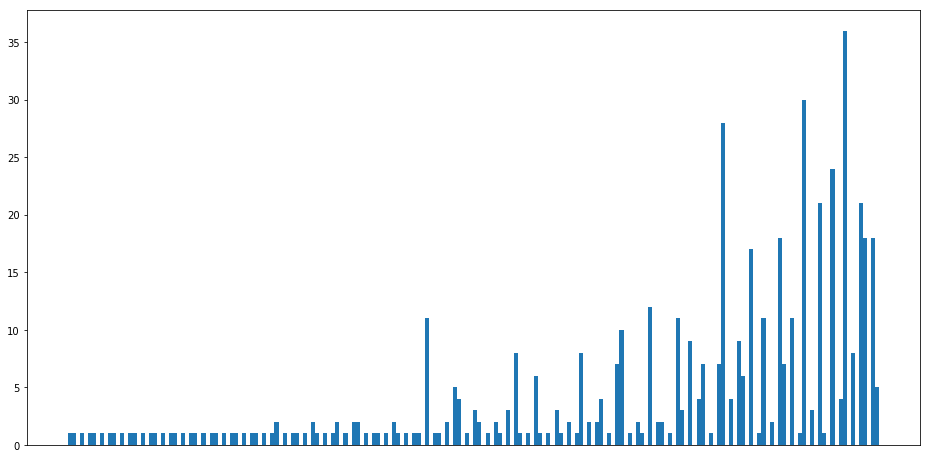

In [86]:
plt.figure(figsize=(16,8))
plt.xticks([])
plt.hist(np_colcounts[:,1],bins=200);

In [87]:
np_colcounts[:,1] = np_colcounts[:,1].astype(np.float)
np_colcounts[0]

array(['multi, blue', '4329.0'], dtype='<U98')

In [88]:
np_colcounts.shape

(522, 2)

In [89]:
(np_colcounts[:,1].astype(np.float).mean(),np.median(np_colcounts[:,1].astype(np.float)))

(79.68582375478927, 21.0)

In [90]:
fcounts = np_colcounts[:,1].astype(np.float)
np_colcounts[fcounts > np.median(fcounts)/2].shape

(366, 2)

In [91]:
def create_rebalancing_dict(counts,multiplier):
    """
    Takes an ordered np.array of counts
    """
    # threshold by median
    fcounts = counts[:,1].astype(np.float)
    counts = counts[fcounts > np.median(fcounts)/2]
    
    output = OrderedDict()
    top_class = counts[0]
    output[top_class[0]] = [multiplier, 0]
    augtop = float(top_class[1]) * multiplier
    for cls_tup in counts[1:]:
        intmult = int(augtop/float(cls_tup[1]))
        addsamp = augtop/float(cls_tup[1]) - intmult
        output[cls_tup[0]] = [intmult, addsamp]
    return output

In [92]:
col_bal_dict = create_rebalancing_dict(np_colcounts,2)
len(col_bal_dict)

366

In [93]:
list(col_bal_dict.items())[:3]

[('multi, blue', [2, 0]),
 ('multi, tan/beige', [2, 0.7652507186202491]),
 ('multi, gray', [2, 0.7705600000000001])]

In [94]:
rug_color_df = filtered_rug_df[['IMAGE_FILE','Color']].dropna()
rug_color_df.columns = ['IMAGE_FILE', 'ATTR_VAL']
rug_color_df.head(2)

,IMAGE_FILE,ATTR_VAL
0,/home/jovyan/vmldata/raw_source_data/v20181129...,"tan/beige, black, gold, brown"
1,/home/jovyan/vmldata/raw_source_data/v20181129...,"tan/beige, black, gold, brown"


In [95]:
def create_rebalanced_df(df, bal_dict):
    dfs_to_concat = []
    for key, val in bal_dict.items():
        temp_df = df.query('ATTR_VAL == "{}"'.format(key))
        temp_dup_dfs = []
        for i in range(val[0]):
            temp_dup_dfs.append(temp_df)
        temp_dup_dfs.append(temp_df.sample(frac=val[1]))
        dfs_to_concat.append(pd.concat(temp_dup_dfs))
    return pd.concat(dfs_to_concat)

In [96]:
aug_rug_col_df = create_rebalanced_df(rug_color_df, col_bal_dict)
aug_rug_col_df.head(2)

,IMAGE_FILE,ATTR_VAL
5201,/home/jovyan/vmldata/raw_source_data/v20181129...,"multi, blue"
5202,/home/jovyan/vmldata/raw_source_data/v20190104...,"multi, blue"


In [97]:
aug_rug_col_df['ATTR_VAL'].value_counts()

green                                                                                               8658
multi, tan/beige, black, blue                                                                       8658
multi, ivory/cream, blue                                                                            8658
multi, tan/beige, gray                                                                              8658
ivory/cream, brown, gold, green, blue                                                               8658
purple, red, yellow, multi, green, blue                                                             8658
tan/beige, gray, blue                                                                               8658
tan/beige, ivory/cream, green                                                                       8658
pink, ivory/cream, tan/beige, red, gold, green, blue                                                8658
orange, multi, blue                                    

### CREATE REBALANCED CSVs

In [98]:
#rug_color_df.columns = ['IMAGE_FILE', 'ATTR_VAL']
# colcounts = OrderedDict(filtered_rug_df['Color'].value_counts())
# np_colcounts = np.array([x for x in colcounts.items()])
# col_bal_dict = create_rebalancing_dict(np_colcounts,2)

In [101]:
INITIAL_MULTIPLIER = 2
use_attrs = ['Color', 'Rug Construction', 'Rug Size', 'Rug Type', 'Rugs Pattern', 'Style']
for attr in use_attrs:
    colcounts = OrderedDict(filtered_rug_df[attr].value_counts())
    np_colcounts = np.array([x for x in colcounts.items()])
    col_bal_dict = create_rebalancing_dict(np_colcounts,INITIAL_MULTIPLIER)
    temp_df = filtered_rug_df[['IMAGE_FILE', attr]].dropna()
    temp_df.columns = ['IMAGE_FILE','ATTR_VAL']
    print("Attribute '{}' has df with shape: {}".format(attr, temp_df.shape))
    temp_df = create_rebalanced_df(temp_df, col_bal_dict)
    print("After augmentation attribute '{}' has df with shape: {}".format(attr, temp_df.shape))
    filename = "../multi_label_train/CSV/Rebal_RUG_" + attr.replace(" ","") + ".csv"
    temp_df.to_csv(filename,index=False)

Attribute 'Color' has df with shape: (41596, 2)
After augmentation ttribute 'Color' has df with shape: (3168828, 2)
Attribute 'Rug Construction' has df with shape: (647, 2)
After augmentation ttribute 'Rug Construction' has df with shape: (2808, 2)
Attribute 'Rug Size' has df with shape: (32469, 2)
After augmentation ttribute 'Rug Size' has df with shape: (272376, 2)
Attribute 'Rug Type' has df with shape: (3472, 2)
After augmentation ttribute 'Rug Type' has df with shape: (29070, 2)
Attribute 'Rugs Pattern' has df with shape: (37304, 2)
After augmentation ttribute 'Rugs Pattern' has df with shape: (575640, 2)
Attribute 'Style' has df with shape: (33409, 2)
After augmentation ttribute 'Style' has df with shape: (415560, 2)


In [103]:
!ls ../multi_label_train/CSV

Rebal_RUG_Color.csv	       Rebal_RUG_RugType.csv	RUG_RugSize.csv
Rebal_RUG_RugConstruction.csv  Rebal_RUG_Style.csv	RUG_RugsPattern.csv
Rebal_RUG_RugSize.csv	       RUG_Color.csv		RUG_RugType.csv
Rebal_RUG_RugsPattern.csv      RUG_RugConstruction.csv	RUG_Style.csv


In [16]:
!ls *.h5

raw_attribute_data_shrek_cleaned.h5  raw_text_data_shrek.h5
raw_attribute_data_shrek.h5	     RUGS_IDM_1118_and_0119_DATA.h5
raw_image_data_denis.h5		     RUGS_IDM_Nov2018_DATA.h5
raw_image_data_patrick.h5	     RUGS_VALIDATION_DATA.h5


In [18]:
zz = pd.read_csv('RUGS_IDM_1118_and_0119_DATA.h5',)
zz.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte